In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python
!sudo apt-get install tesseract-ocr-eng
!pip install h5py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,076 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [3]:
import cv2 as cv
import numpy as np
import pytesseract as tsr
from matplotlib import pyplot as plt
import imutils
import h5py

In [4]:
IMG_DIR = '/content/drive/MyDrive/Images/Meteran2.jpg'
H5_FILE = '/content/drive/MyDrive/Images/resultMeteran.h5'

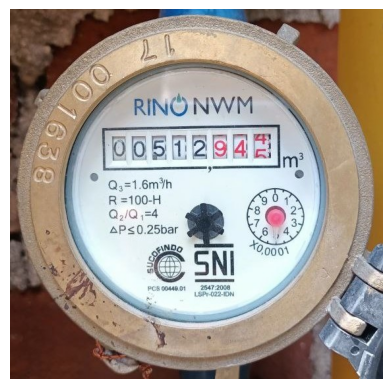

In [5]:
# Load image
image = cv.imread(IMG_DIR)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Display the original image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

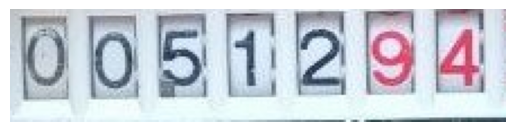

In [6]:
# Menentukan ROI (Region of Interest) dalam bentuk kotak pembatas (x, y, w, h)
ROI = (150, 190, 220, 50)

# Memotong ROI dari gambar asli
x, y, w, h = ROI
ROI_image = image[y:y+h, x:x+w]

# Menampilkan ROI
plt.imshow(cv.cvtColor(ROI_image, cv.COLOR_RGB2BGR))
plt.axis('off')
plt.show()

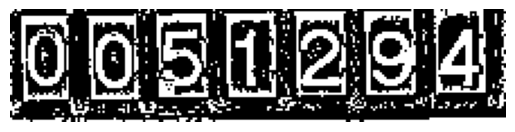

In [7]:
# Convert to grayscale
gray = cv.cvtColor(ROI_image, cv.COLOR_RGB2GRAY)

# Apply GaussianBlur to reduce noise
blur = cv.GaussianBlur(gray, (1, 1), 0)

# Apply adaptive thresholding
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 1)

# Display thresholded image
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# Melakukan prapemrosesan untuk pengenalan teks pada ROI
gray = cv.cvtColor(ROI_image, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (1, 1), 0)  # Mengurangi noise dengan GaussianBlur
thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
dist = cv.distanceTransform(thresh, cv.DIST_L2, 5)
dist = cv.normalize(dist, dist, 5, 1.0, cv.NORM_MINMAX)
dist = (dist * 255).astype('uint8')
dist = cv.threshold(dist, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# Define kernel for dilation
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (1, 1))
dilation = cv.dilate(thresh, kernel, iterations=1)
opening = cv.morphologyEx(dist, cv.MORPH_OPEN, kernel)

# Find contours
cnts = cv.findContours(opening.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

nums = []
for c in cnts:
    (x, y, w, h) = cv.boundingRect(c)
    if w >= 15 and h > 20:
        nums.append(c)

if nums:
    nums = np.vstack([nums[i] for i in range(0, len(nums))])
    null = cv.convexHull(nums)

    mask = np.zeros(dilation.shape[:2], dtype='uint8')
    cv.drawContours(mask, [null], -1, 255, -1)
    mask = cv.dilate(mask, None, iterations=2)

    final = cv.bitwise_and(opening, opening, mask=mask)

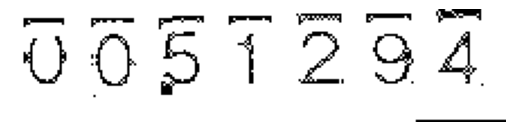

Teks Hasil Bacaan Angka:  0051294



In [9]:
# Menampilkan gambar hasil
plt.imshow(final, cmap='gray')
plt.axis('off')
plt.show()

# Detect text using Tesseract OCR
config = "--psm 6"
text = tsr.image_to_string(final, config=config)
print("Teks Hasil Bacaan Angka: ", text)

In [11]:
# Save results to HDF5 file
with h5py.File(H5_FILE, 'w') as hf:
    hf.create_dataset('image_rgb', data=image_rgb)
    hf.create_dataset('gray', data=gray)
    hf.create_dataset('blur', data=blur)
    hf.create_dataset('thresh', data=thresh)
    hf.create_dataset('dilation', data=dilation)
    hf.create_dataset('final', data=final)
    hf.create_dataset('text', data=text.encode('utf8'))  # Convert text to bytes

print(f"Data has been saved to {H5_FILE}")

Data has been saved to /content/drive/MyDrive/Images/resultMeteran.h5
